In [2]:
#load all libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder


In [4]:
# Load train dataset
df = pd.read_csv('dataset/train.csv')
# Load features dataset and join it with train data
features_df = pd.read_csv('dataset/features.csv')
df = pd.merge(df, features_df.drop(['IsHoliday'], axis = 1), how = 'left', on = ['Store', 'Date'])
# Load store dataset and join with above data
stores_df = pd.read_csv('dataset/stores.csv')
df = pd.merge(df, stores_df, how = 'left', on = ['Store'])
df.shape



(421570, 16)

In [5]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [6]:
# Let's explore variables, their data types, and total non-null values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [7]:
# summary statistics of the dataset
df[['Weekly_Sales', 'Temperature', 'CPI', 'Size']].describe()


,Weekly_Sales,Temperature,CPI,Size
count,421570.000000,421570.000000,421570.000000,421570.000000
mean,15981.258123,60.090059,171.201947,136727.915739
std,22711.183519,18.447931,39.159276,60980.583328
min,-4988.940000,-2.060000,126.064000,34875.000000
25%,2079.650000,46.680000,132.022667,93638.000000
50%,7612.030000,62.090000,182.318780,140167.000000
75%,20205.852500,74.280000,212.416993,202505.000000
max,693099.360000,100.140000,227.232807,219622.000000


In [8]:
print('Min Date in Data is - {}'.format(df['Date'].min()))
print('Max Date in Data is - {}'.format(df['Date'].max()))


Min Date in Data is - 2010-02-05
Max Date in Data is - 2012-10-26


  Type  Store
0    A     22
1    B     17
2    C      6


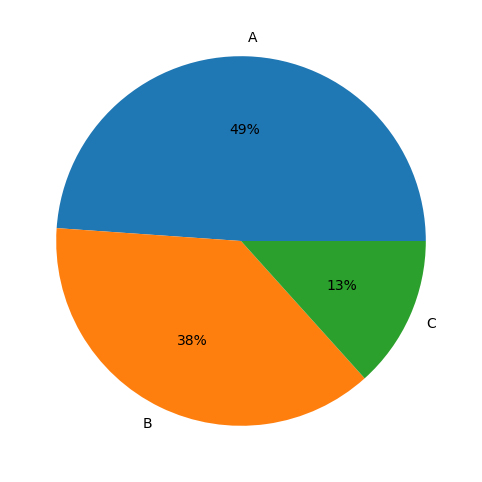

In [9]:
temp = pd.DataFrame(df.groupby('Type')['Store'].nunique()).reset_index()
print(temp)
plt.figure(figsize = (12,6))
plt.pie(temp['Store'], labels = temp['Type'], autopct = '%.0f%%')
plt.show()


<Axes: xlabel='Type', ylabel='Size'>

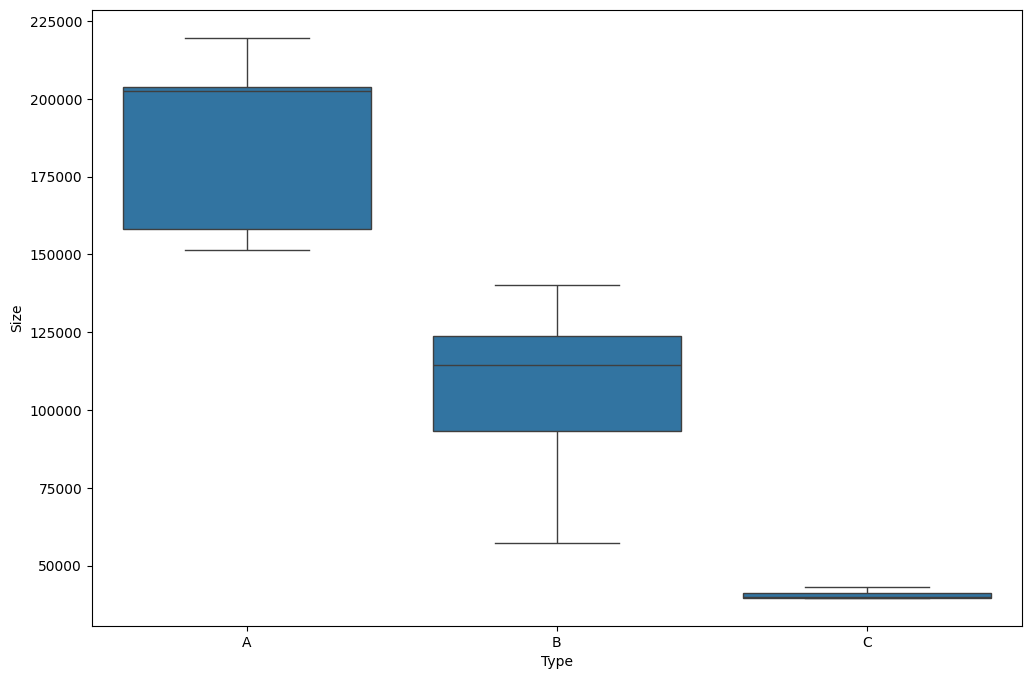

In [10]:
# size distribution of stores for each store type
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Size', data = df, showfliers = False)


<Axes: xlabel='Type', ylabel='Weekly_Sales'>

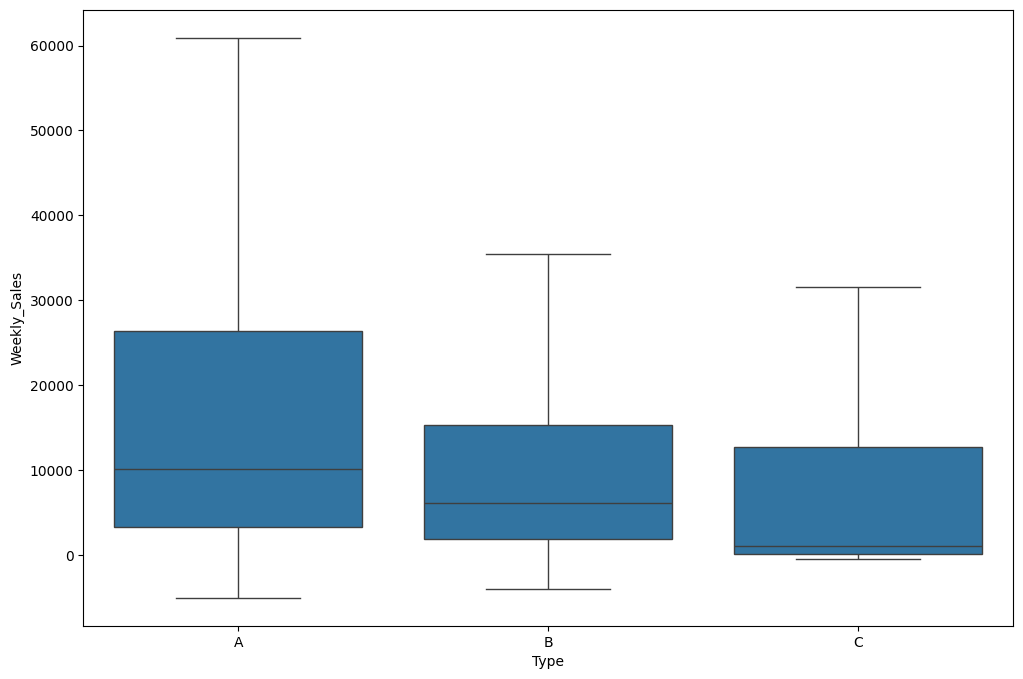

In [11]:
# Distribution of weekly sales based on store type
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Weekly_Sales', data = df, showfliers = False)


<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

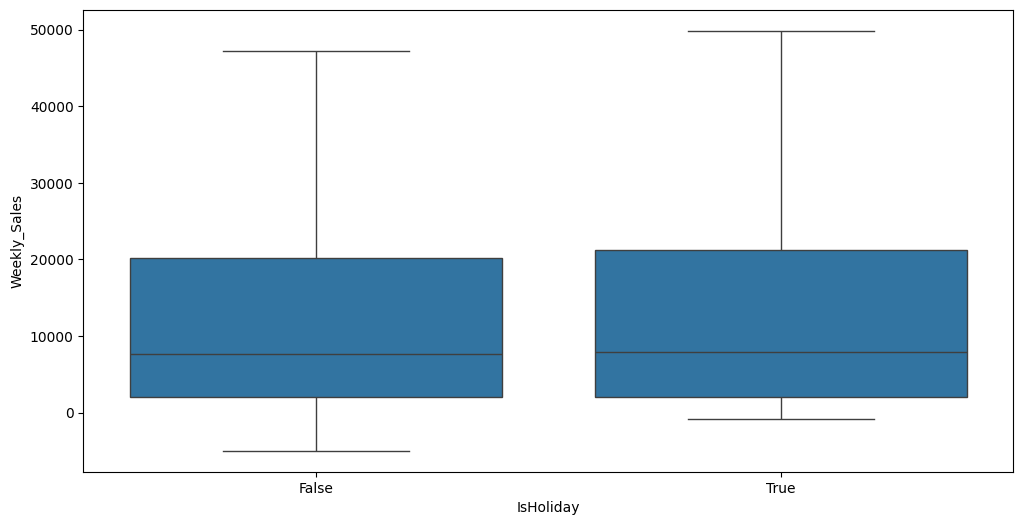

In [12]:
# impact of holidays on weekly sales
plt.figure(figsize = (12,6))
sns.boxplot(x = 'IsHoliday', y ='Weekly_Sales', data = df, showfliers = False)


<Axes: >

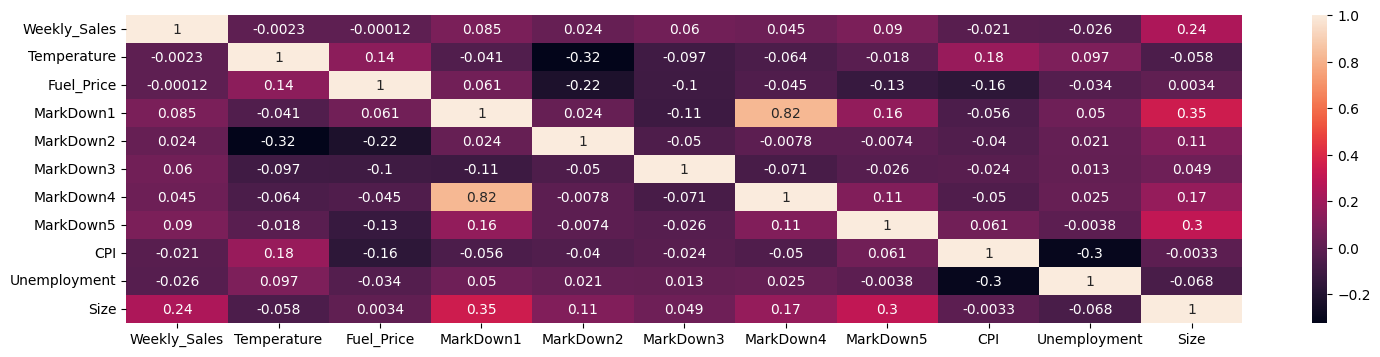

In [13]:
feature_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size']
plt.figure(figsize = (18,4))
sns.heatmap(df[feature_cols].corr(), annot = True)


Data Preprocessing

In [14]:
# Impute NULL values
df['MarkDown1'] = df['MarkDown1'].fillna(0)
df['MarkDown2'] = df['MarkDown2'].fillna(0)
df['MarkDown3'] = df['MarkDown3'].fillna(0)
df['MarkDown4'] = df['MarkDown4'].fillna(0)
df['MarkDown5'] = df['MarkDown5'].fillna(0)

# create year, month, and date
df['Date'] = pd.to_datetime(df['Date'])
df['month_date'] = df['Date'].apply(lambda i : i.month)
df['day_date'] = df['Date'].apply(lambda i : i.day)
df['year_date'] = df['Date'].apply(lambda i : i.year)

# one hot encoding
cols_to_encode = ['Type', 'IsHoliday']
df = pd.get_dummies(data = df, columns = cols_to_encode, drop_first = True)

# Standard Scaler
standard_scaler = StandardScaler()
feature_cols = ['Temperature', 'Fuel_Price', 'MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
transformed_features = standard_scaler.fit_transform(df[feature_cols])

df[feature_cols] = transformed_features

# split data into train and test
feature_cols  = df.columns.tolist()
feature_cols = [i for i in feature_cols if i not in ['Date', 'Weekly_Sales']]
x_train, x_test, y_train, y_test = train_test_split(df[feature_cols], df['Weekly_Sales'], test_size = 0.2, random_state = 1234)


In [31]:
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,month_date,day_date,year_date,Type_B,Type_C,IsHoliday_True
0,1,1,2010-02-05,24924.50,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,1.018774,0.078201,0.239209,2,5,2010,False,False,False
1,1,1,2010-02-12,46039.49,-1.169783,-1.773177,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,1.022498,0.078201,0.239209,2,12,2010,False,False,True
2,1,1,2010-02-19,41595.55,-1.092810,-1.847330,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,1.023697,0.078201,0.239209,2,19,2010,False,False,False
3,1,1,2010-02-26,19403.54,-0.729625,-1.744825,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,1.024476,0.078201,0.239209,2,26,2010,False,False,False
4,1,1,2010-03-05,21827.90,-0.736672,-1.605243,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,1.025255,0.078201,0.239209,3,5,2010,False,False,False


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           421570 non-null  int64         
 1   Dept            421570 non-null  int64         
 2   Date            421570 non-null  datetime64[ns]
 3   Weekly_Sales    421570 non-null  float64       
 4   Temperature     421570 non-null  float64       
 5   Fuel_Price      421570 non-null  float64       
 6   MarkDown1       421570 non-null  float64       
 7   MarkDown2       421570 non-null  float64       
 8   MarkDown3       421570 non-null  float64       
 9   MarkDown4       421570 non-null  float64       
 10  MarkDown5       421570 non-null  float64       
 11  CPI             421570 non-null  float64       
 12  Unemployment    421570 non-null  float64       
 13  Size            421570 non-null  float64       
 14  month_date      421570 non-null  int

KNN regression model

In [15]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors = 10, n_jobs = 4)
knn_regressor.fit(x_train, y_train)
y_pred = knn_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {knn_regressor.score(x_test, y_test)}')


MAE is - 8762.91461735892
RMSE is - 15006.052941651613
Accuracy Score is - 0.56866887793634


<Axes: xlabel='Weekly_Sales'>

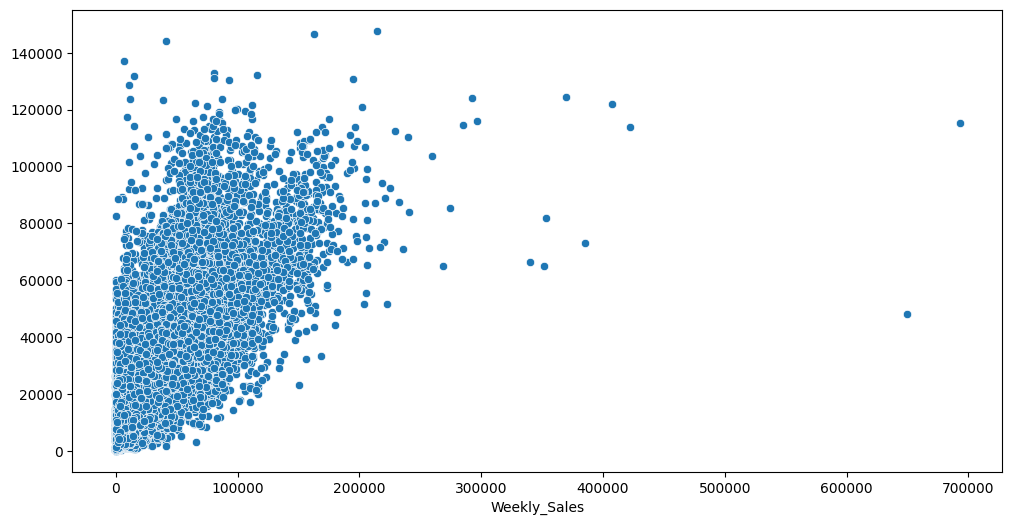

In [16]:
# scatter plot between observed and predicted values of weekly sales from KNN regressor
plt.figure(figsize = (12,6))
sns.scatterplot(x = y_test, y = y_pred)


Decision Tree Regressor

In [17]:
from sklearn.tree import DecisionTreeRegressor
decision_tree_regressor = DecisionTreeRegressor(random_state = 1234)
decision_tree_regressor.fit(x_train, y_train)
y_pred = decision_tree_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {decision_tree_regressor.score(x_test, y_test)}')


MAE is - 1862.3314530208509
RMSE is - 5288.265744618374
Accuracy Score is - 0.9464321286835593


Random Forest Regressor

In [18]:
rf_regressor = RandomForestRegressor(n_estimators = 400, max_depth = 15, random_state = 1234, n_jobs = 5)
rf_regressor.fit(x_train, y_train)
y_pred = rf_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {rf_regressor.score(x_test, y_test)}')


MAE is - 1946.5927149154704
RMSE is - 4582.062947220819
Accuracy Score is - 0.9597839003106834


XGBoost Regressor

In [19]:
xgb_regressor = XGBRegressor(objective = 'reg:linear', n_estimators = 500, max_depth = 6, nthread = 4, learning_rate = 0.5, random_state = 1234)
xgb_regressor.fit(x_train, y_train)
y_pred = xgb_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {xgb_regressor.score(x_test, y_test)}')


c:\Users\Admin\Desktop\walmart\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


MAE is - 2000.5589102001231
RMSE is - 4026.2203064516416
Accuracy Score is - 0.9689491912486072


<Axes: xlabel='Weekly_Sales'>

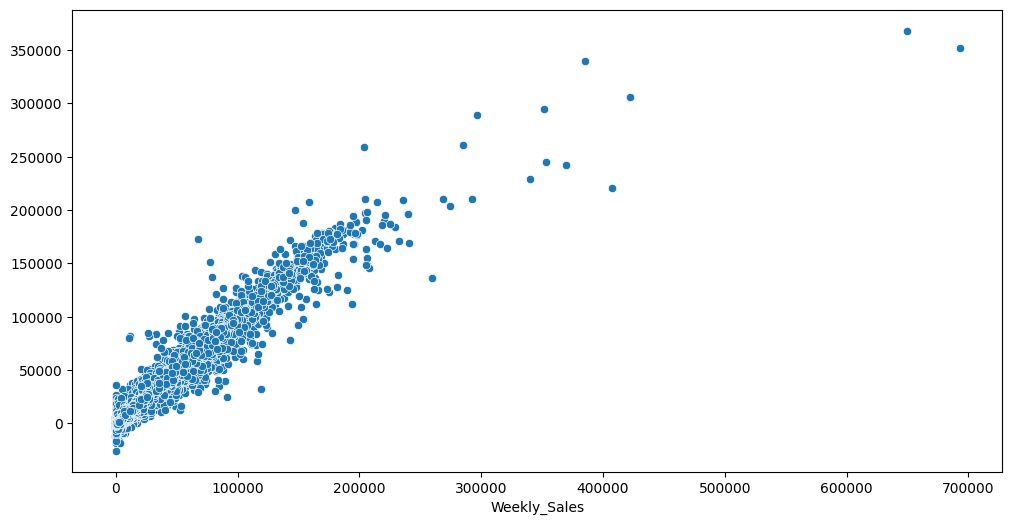

In [20]:
# scatter plot between observed and predicted values of weekly sales from XGBoost regressor
plt.figure(figsize = (12,6))
sns.scatterplot(x = y_test, y = y_pred)


In [30]:
import joblib 
joblib.dump(xgb_regressor, "model.pkl") 
model = joblib.load('model.pkl' ) 
prediction=model.predict(x_test)
output = '{0:.2f}'.format(prediction[0])
# output = ', '.join(['{0:.2f}'.format(pred) for pred in prediction])
output


'-4923.26'